# Estimating Absolute Binding Free Energies from Relative Affinities

One of the strengths of ``cinnabar`` is that it provides a simulation-agnostic way to estimate absolute binding affinities from relative binding free energy (RBFE) data.

This capability is essential in two common use cases:

- **Prospective applications**, where the ultimate goal is to rank ligands by predicted potency.
- **Benchmarking exercises**, where we want to assess how well RBFE calculations recover experimental rankings.

In this tutorial, we will walk step-by-step through the construction of an ``FEMap`` - the central object in cinnabar - and show how it can be used to extract **absolute affinity estimates** using the [maximum likelihood estimation (MLE) approach](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00528).

## Loading Example RBFE Results

For this example, we will use some RBFE data generated with [OpenFE](https://docs.openfree.energy/en/latest/)
, which is included with ``cinnabar``’s test suite. You can easily swap this out with your own RBFE outputs.

In [1]:
from cinnabar.femap import FEMap
from openff.units import unit
import numpy as np

# load the results
rbfe_results = {}
with open("../cinnabar/data/example.csv", "r") as f:
    for line in f.readlines()[41:]:
        ligand_a, ligand_b, calculated, uncertainty, _ = line.strip().split(",")
        rbfe_results[(ligand_a, ligand_b)] = {
            "calculated": float(calculated),
            "uncertainty": float(uncertainty)
        }

## Creating the ``FEMap``

We now create an empty ``FEMap`` object and begin adding the relative calculations.

There are two ways to add data:

- ``add_measurement``: accepts a ``Measurement`` object (most general option, supports relative and absolute values).
- ``add_relative_calculation``: a convenience wrapper that automatically builds a ``Measurement`` for you.

Here we’ll use the convenience method:

In [2]:
femap = FEMap()
for (ligand_a, ligand_b), result in rbfe_results.items():
    femap.add_relative_calculation(
        labelA=ligand_a,
        labelB=ligand_b,
        value=result["calculated"] * unit.kilocalorie_per_mole,
        uncertainty=result["uncertainty"] * unit.kilocalorie_per_mole,
        source="OpenFE",
    )

<div class="alert alert-block alert-info"> <b>Note:</b> The MLE solver currently expects a single measurement for each relative estimate. If you have repeats (or both forward and backward directions), it is best to combine them before adding to the ``FEMap``. </div>

## Inspecting the FEMap

The ``FEMap`` object exposes some useful properties for sanity checking:

In [3]:
print(femap.n_ligands)     # number of ligands
print(femap.degree)        # average degree of the graph

36
1.6111111111111112


A key property to consider is whether the graph is fully connected, that is, whether all results are reachable from other results. The ``FEMap`` object provides a method to check this and a visualisation method which can be helpful to identify missing connections in the network.

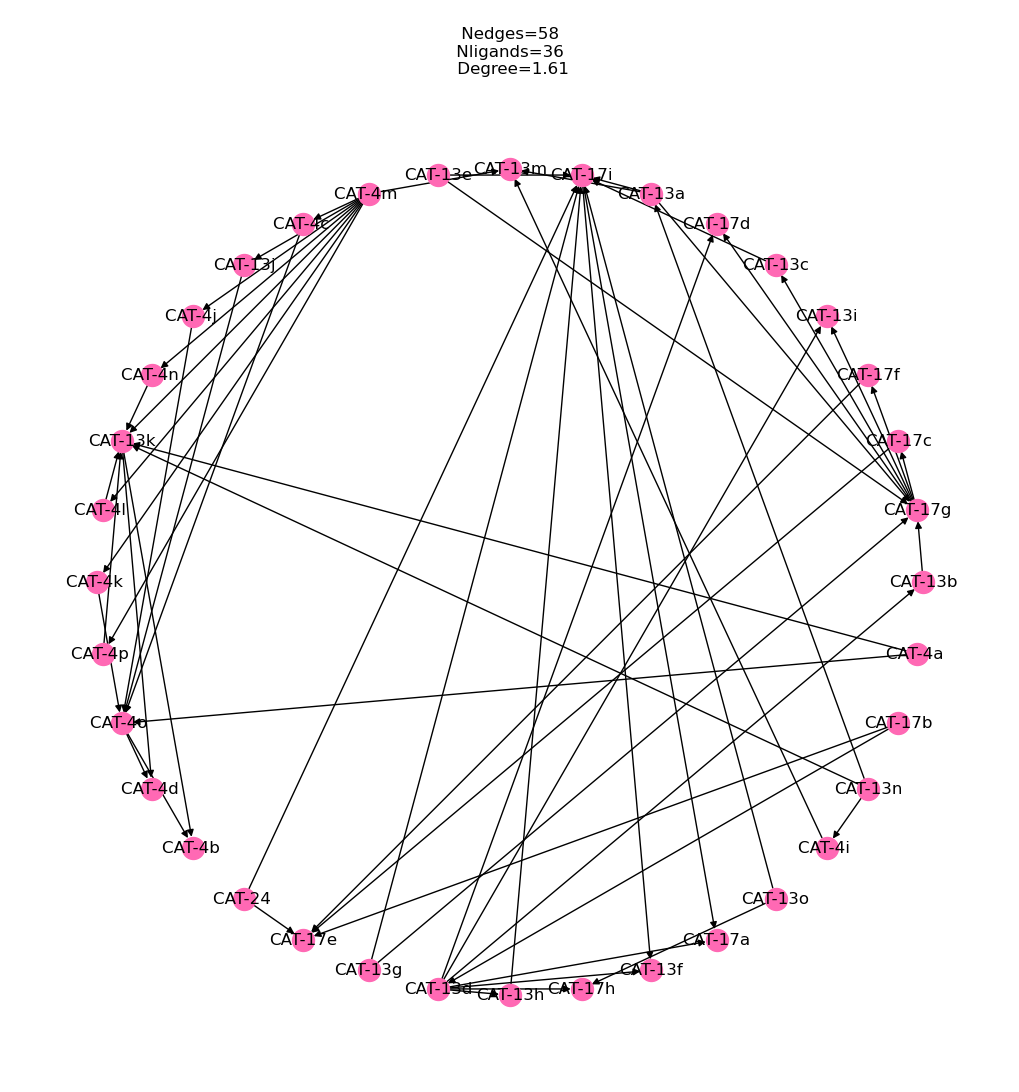

In [4]:
# make sure the graph is fully connected
assert femap.check_weakly_connected()
femap.draw_graph()

## Estimating Absolute Binding Affinities

Once we have a connected network, we can run the ``MLE`` solver to generate absolute free energies.

This modifies the ``FEMap`` in place:

In [5]:
# this will modify the graph in place adding the MLE estimated values
femap.generate_absolute_values()
absolute_df = femap.get_absolute_dataframe()
absolute_df

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
0,CAT-13b,0.378864,0.102983,MLE,True
1,CAT-17g,0.293719,0.069740,MLE,True
2,CAT-17c,-1.540067,0.092647,MLE,True
3,CAT-17f,-1.074339,0.087225,MLE,True
4,CAT-13i,-1.031916,0.108354,MLE,True
5,CAT-13c,0.028110,0.099052,MLE,True
6,CAT-17d,1.377536,0.082133,MLE,True
7,CAT-13a,0.503213,0.066349,MLE,True
8,CAT-17i,-0.027499,0.070761,MLE,True
9,CAT-13m,-0.811262,0.088522,MLE,True


We can now rank the ligands by predicted potency:

In [6]:
ranked_df = absolute_df.sort_values(by="DG (kcal/mol)", ascending=True)
ranked_df

,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
23,CAT-24,-2.992521,0.085422,MLE,True
30,CAT-17a,-1.989695,0.085190,MLE,True
34,CAT-17b,-1.570340,0.092320,MLE,True
2,CAT-17c,-1.540067,0.092647,MLE,True
26,CAT-13d,-1.211377,0.075449,MLE,True
10,CAT-13e,-1.136890,0.099052,MLE,True
28,CAT-17h,-1.122264,0.094168,MLE,True
24,CAT-17e,-1.110508,0.082703,MLE,True
3,CAT-17f,-1.074339,0.087225,MLE,True
4,CAT-13i,-1.031916,0.108354,MLE,True


## Applying an Experimental Shift

The MLE-generated absolute values are always **centered around 0**, which is fine for ranking a single ligand series, however you might find it useful for **visualization or communication** to apply an experimental shift to the predicted values to align the means of the predicted and measured affinities. 

In [7]:
experimental_ddgs = []
with open("../cinnabar/data/example.csv", "r") as f:
    for line in f.readlines()[2:38]:
        _, ddg, _ = line.strip().split(",")
        experimental_ddgs.append(float(ddg))
mean_shift = np.mean(experimental_ddgs)
# subtract the mean of the calculated absolute values
ranked_df["DG (kcal/mol)"] -= ranked_df["DG (kcal/mol)"].mean()
# shift by the experimental mean
ranked_df["DG (kcal/mol)"] += mean_shift
ranked_df


,label,DG (kcal/mol),uncertainty (kcal/mol),source,computational
23,CAT-24,-12.318910,0.085422,MLE,True
30,CAT-17a,-11.316084,0.085190,MLE,True
34,CAT-17b,-10.896729,0.092320,MLE,True
2,CAT-17c,-10.866456,0.092647,MLE,True
26,CAT-13d,-10.537766,0.075449,MLE,True
10,CAT-13e,-10.463279,0.099052,MLE,True
28,CAT-17h,-10.448653,0.094168,MLE,True
24,CAT-17e,-10.436897,0.082703,MLE,True
3,CAT-17f,-10.400727,0.087225,MLE,True
4,CAT-13i,-10.358305,0.108354,MLE,True


## Recap

 - ``cinnabar`` provides a **simulation-agnostic API** for absolute binding affinity estimation from RBFE networks.
- ``FEMap`` is built by adding relative calculations (via ``add_relative_calculation`` or ``add_measurement``).
- The network connectivity can be checked with ``FEMap.check_weakly_connected()``.
- Absolute affinities are generated in place using ``FEMap.generate_absolute_values()`` and retrieved with ``FEMap.get_absolute_dataframe()``.
- Predicted absolute affinities are centered around ``0``, but can be shifted to align with experiment if needed.

That completes the basic tutorial of using the ``cinnabar`` API for absolute affinity estimation. Hopefully, this demonstrates the flexibility of the API and gives you an idea of how this might be incorporated into a free energy pipeline using any relative free energy prediction software.